# Notebook 3: Exploratory Data Analysis

I will examine different trends in the genre, word count, and sentiment scores within the `mov_combo_final` dataset. Since many movies fall under a variety of genres, I will first prepare the dataset by one hot encoding separate genre columns.

Trends will be examined per movie and also per genre. Histograms will be used to examine the total word count distribution among movie characters as well as their sentiment score. Barplots will be used to examine the average and total number of characters per genre as well as their average and total lines per genre. Furthermore, TF-IDF will be utilized to examine the top most important words for each genre. The purpose is to gain a deeper understanding of how the characters' texts have predictive values in its similarities with one another.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle, re, string
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from nltk.tokenize import RegexpTokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('fivethirtyeight')

### Preparing Dataset

In [2]:
mov_combo_final = pd.read_pickle('../data/mov_combo_final.pkl')
mov_combo_final = mov_combo_final.drop(['imdb_url','pic_url'],1)
mov_combo_final.head(3)

,imdb_title,character,text,tokenized_text,word_count,vader,genre
0,10 Things I Hate About You (1999),bartender,What can I get you? You forgot to pay!,"[What, can, I, get, you, You, forgot, to, pay]",9,"{'neg': 0.195, 'neu': 0.805, 'pos': 0.0, 'comp...","[Comedy, Drama, Romance]"
1,10 Things I Hate About You (1999),bianca,Did you change your hair? You might wanna thin...,"[Did, you, change, your, hair, You, might, wan...",1295,"{'neg': 0.108, 'neu': 0.726, 'pos': 0.166, 'co...","[Comedy, Drama, Romance]"
2,10 Things I Hate About You (1999),bianca and walter,The sound of a fifteen-year-old in labor.,"[The, sound, of, a, fifteen, year, old, in, la...",9,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","[Comedy, Drama, Romance]"


I need to re-tokenize the `text` column in order to examine each word and also remove common stop words

In [3]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+') 

In [4]:
mov_combo_final['tokenized_text'] = mov_combo_final['text'].map(lambda x: tokenizer.tokenize(x.lower()))

Removing single letter words except for 'i' or 'I' from each observed `tokenized_text`

In [5]:
single_letters = list(string.ascii_lowercase)+list(string.ascii_uppercase)
single_letters.remove('i')
single_letters.remove('I')

for i in range(len(mov_combo_final['tokenized_text'])):
    mov_combo_final.at[i,'tokenized_text'] = [word for word in mov_combo_final['tokenized_text'][i] 
                                              if word not in single_letters]

Re-creating the `word_count` based on the new `tokenized_text`:

In [6]:
mov_combo_final['word_count'] = mov_combo_final['tokenized_text'].map(lambda x: len(x))

I am going to create two new columns, `char_count` and `vader_compound`, to examine additional features. The `char_count` is the character count and the `vader_compound` provides the overall sentiment score. The compound score ranges between -1 to +1, from most extreme negative to most extreme positive.

In [7]:
mov_combo_final['vader_cmpd'] = mov_combo_final['vader'].map(lambda x: x['compound'])  

In [8]:
mov_combo_final['char_count'] = mov_combo_final['text'].map(lambda x: len(x))

In [9]:
mov_combo_final.describe().T

,count,mean,std,min,25%,50%,75%,max
word_count,76127.0,130.597002,432.190671,0.0,9.000,22.0,60.00000,12203.0
vader_cmpd,76127.0,0.059934,0.549209,-1.0,-0.296,0.0,0.48045,1.0
char_count,76127.0,714.205761,2336.120481,1.0,51.000,123.0,338.00000,66994.0


In [10]:
mov_combo_final.sort_values('genre').head(3)

,imdb_title,character,text,tokenized_text,word_count,vader,genre,vader_cmpd,char_count
58327,The Day the Clown Cried (1972),galt,We might as well be outside. What is it? It's ...,"[we, might, as, well, be, outside, what, is, i...",477,"{'neg': 0.082, 'neu': 0.817, 'pos': 0.101, 'co...",[],0.8344,2534
58324,The Day the Clown Cried (1972),first guard,Their clothes! They've got to undress.,"[their, clothes, they, ve, got, to, undress]",7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",[],0.0000,38
58323,The Day the Clown Cried (1972),czech girl,Inga. Inga!,"[inga, inga]",2,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",[],0.0000,11


The Day the Clown Cried (1972) is apparently missing a genre. According to [IMDb](https://www.imdb.com/title/tt0068451/), its genre should be 'Drama'.

In [11]:
mov_combo_final.loc[mov_combo_final['imdb_title']=='The Day the Clown Cried (1972)', 'genre'] = 'Drama'

### Creating Genre Columns

For filtering and grouping purposes, I will create separate columns for each genre through one hot encoding. Many movies are a blend of multiple genres, so there will be overlap among the features associated with each genre.

Creating a column that has the number of genre(s):

In [12]:
mov_combo_final['num_genre'] = mov_combo_final['genre'].map(lambda x: len(x))

# The following movie has to be encoded because it is a string unlike the rest of the values 
mov_combo_final.loc[mov_combo_final['imdb_title']=='The Day the Clown Cried (1972)', 'num_genre'] = 1

Converting the `genre` column to a string.

In [13]:
mov_combo_final['genre'] = mov_combo_final['genre'].astype(str)
mov_combo_final['genre'] = mov_combo_final['genre'].map(lambda x: x.replace('[',''))
mov_combo_final['genre'] = mov_combo_final['genre'].map(lambda x: x.replace(']',''))
mov_combo_final['genre'] = mov_combo_final['genre'].map(lambda x: x.replace("'",''))
mov_combo_final['genre'] = mov_combo_final['genre'].map(lambda x: x.replace(' ',''))
mov_combo_final['genre'] = mov_combo_final['genre'].map(lambda x: x.strip())
mov_combo_final['genre'].head()

0    Comedy,Drama,Romance
1    Comedy,Drama,Romance
2    Comedy,Drama,Romance
3    Comedy,Drama,Romance
4    Comedy,Drama,Romance
Name: genre, dtype: object

In [14]:
unique_genres = set()
mov_combo_final['genre'].map(lambda x: unique_genres.update(set(x.split(','))))
unique_genres

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War',
 'Western'}

One hot encoding genres to examine word count per genre:

In [15]:
unique_genres = list(unique_genres)
unique_genres.sort()

In [16]:
# creating a column for each genre
for unique_genre in unique_genres:
    mov_combo_final[unique_genre] = 0

# encoding genres
for genre in unique_genres:
    idx = list(mov_combo_final[mov_combo_final['genre'].str.contains(genre)].index)
    mov_combo_final.loc[idx, genre] = 1

### Movie Year Column

In [17]:
per_mov = mov_combo_final.drop_duplicates('imdb_title')
per_mov.head(1)

,imdb_title,character,text,tokenized_text,word_count,vader,genre,vader_cmpd,char_count,num_genre,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,10 Things I Hate About You (1999),bartender,What can I get you? You forgot to pay!,"[what, can, i, get, you, you, forgot, to, pay]",9,"{'neg': 0.195, 'neu': 0.805, 'pos': 0.0, 'comp...","Comedy,Drama,Romance",-0.1759,38,3,...,0,0,0,1,0,0,0,0,0,0


Creating a `year` column that indicates when the movie was released in theaters. Every IMDb title has the release year in parentheses at the end of the title, so I am going to remove all non-numeric characters and select the last four digits

In [18]:
year_column = per_mov['imdb_title'].map(lambda x: re.sub('[^0-9]*','',x)[-4:])

In [19]:
per_mov['year'] = year_column

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
per_mov[['imdb_title','year']].sort_values('year').head()

,imdb_title,year
41308,Neuromancer,
44587,Plastic Man,
34508,Labor of Love,
74914,White Jazz,
38752,Metropolis (1927),1927


Manually inputting missing years for the four movies above:

In [21]:
per_mov.at[41308,'year'] = 1990
per_mov.at[44587,'year'] = 2017
per_mov.at[34508,'year'] = 1976
per_mov.at[74914,'year'] = 2007

per_mov['year'] = per_mov['year'].astype(int)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Histogram - Total Word Count

I will examine how the distribution of the characters' word count and the vader compound score changes based on the verbosity of each character's word count. 

In [22]:
@interact
def total_distribution(min_num_words = 5000, max_num_words = 10000):
    x = mov_combo_final
    x = x[(x['word_count'] > min_num_words)&(x['word_count'] < max_num_words)]
    
    mov_numeric_cols = ['word_count',  'vader_cmpd']
    fig = plt.figure(figsize=(20,10))
    for i, col in enumerate(mov_numeric_cols): # for index and column name 
        fig.add_subplot(2,4,1+i) # create subplots, use index to increment 
        col_data = x[col] 
        plt.hist(col_data, bins=15, color = 'purple')
        plt.title(f'Total {col.upper()} Distribution', fontsize = 12)
        
    return f'There are {len(x)} characters between {min_num_words} and {max_num_words} words in their lines'

interactive(children=(IntSlider(value=5000, description='min_num_words', max=15000, min=-5000), IntSlider(value=10000, description='max_num_words', max=30000, min=-10000), Output()), _dom_classes=('widget-interact',))

While toggling the minimum and maximum word counts, there is a heavy positive skew for the total `word_count` distribution. Furthermore, the vader compound score is quite binary. Most of the character lines have a positive sentiment (vader compound score of 1) and some have a negative sentiment.

The following histogram displays the count of characters that have a word count above 10 words. As you can see, most have a neutral sentiment score (vader compound score of 0). A neutral sentiment score most likely derives from short movie lines in which there are not enough words to express one's sentiment. 

In [23]:
mov_combo_final[mov_combo_final['vader_cmpd'] == 0]['word_count'].max()

174

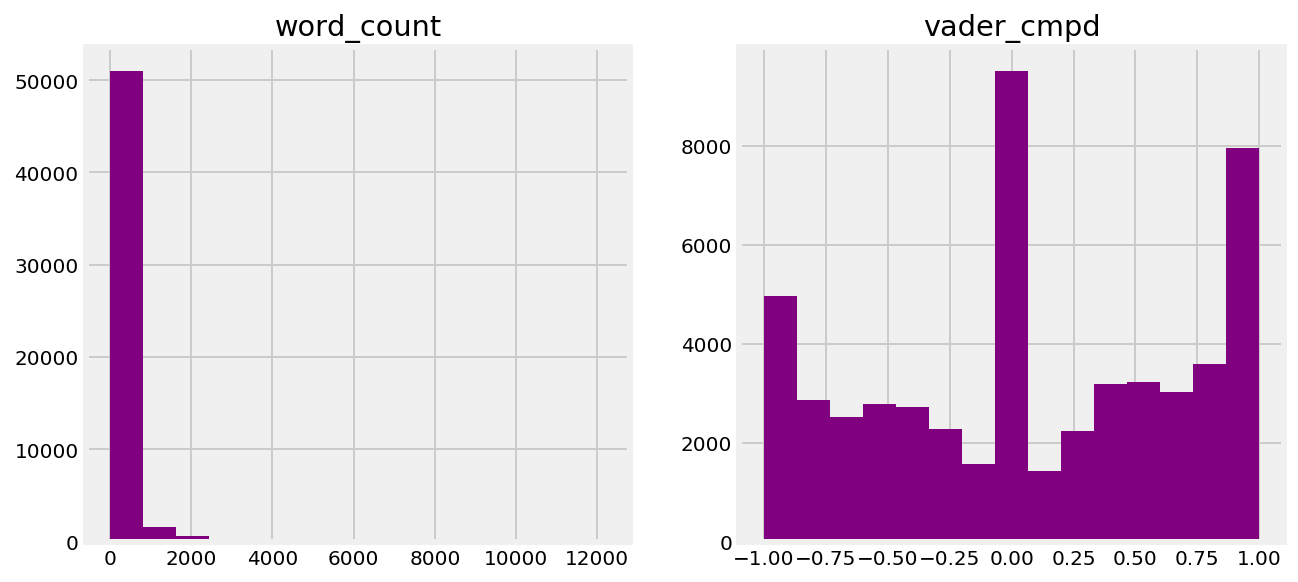

In [24]:
x = mov_combo_final
x = x[(x['word_count'] > 10)]

mov_numeric_cols = ['word_count',  'vader_cmpd']
fig = plt.figure(figsize=(20,10))
for i, col in enumerate(mov_numeric_cols): # for index and column name 
    fig.add_subplot(2,4,1+i) # create subplots, use index to increment 
    col_data = x[col] 
    plt.hist(col_data, bins=15, color = 'purple')
    plt.title(col)

Once the word count is greater than 50 words, the sentiment score distribution becomes more polarized.

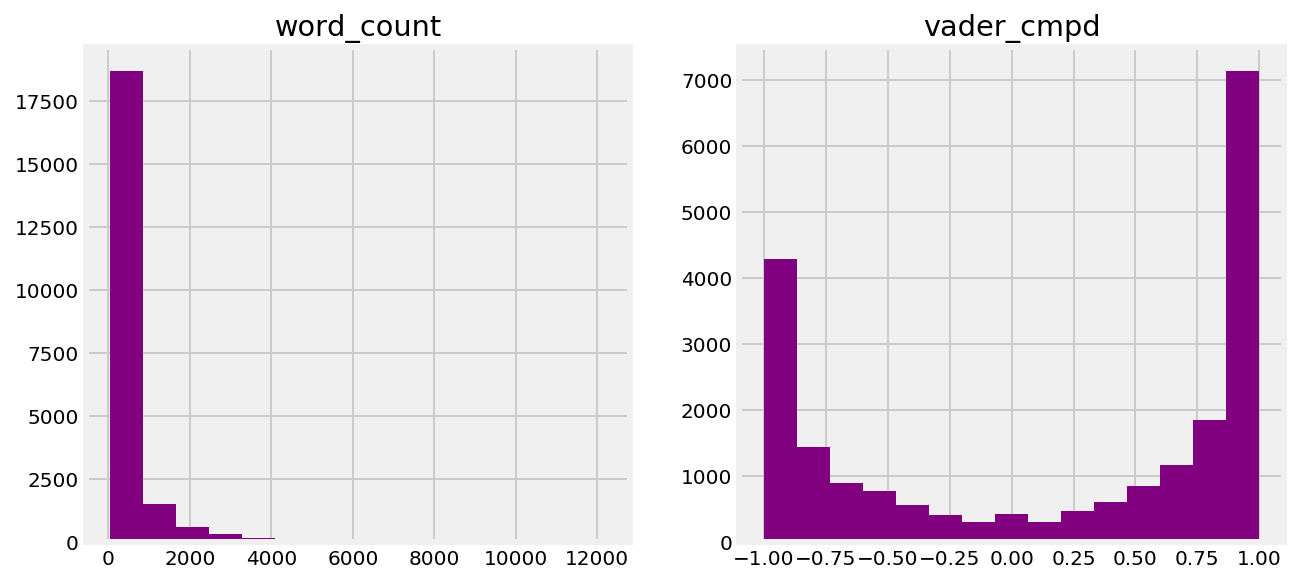

In [25]:
x = mov_combo_final
x = x[(x['word_count'] > 50)]

mov_numeric_cols = ['word_count',  'vader_cmpd']
fig = plt.figure(figsize=(20,10))
for i, col in enumerate(mov_numeric_cols): # for index and column name 
    fig.add_subplot(2,4,1+i) # create subplots, use index to increment 
    col_data = x[col] 
    plt.hist(col_data, bins=15, color = 'purple')
    plt.title(col)

### Count of Genres per Movie

I am going to display how many movies have multiple genre(s).

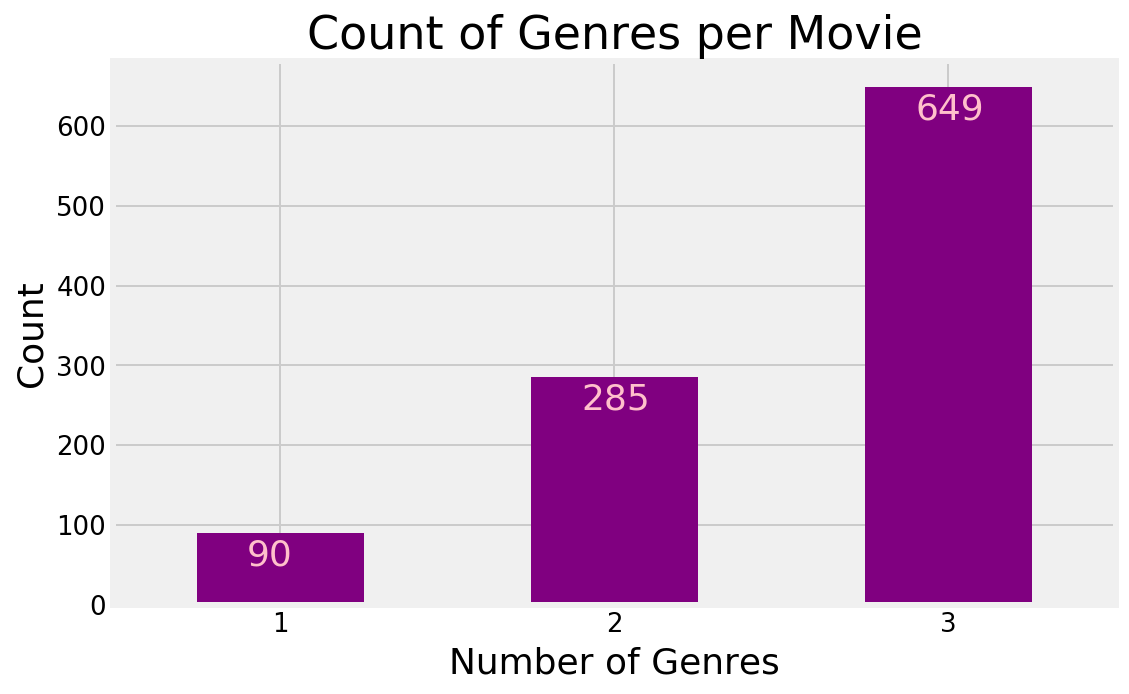

In [26]:
ax = per_mov['num_genre'].value_counts().sort_values().plot(kind='bar', figsize = (8,5), 
                                         color = 'purple', fontsize = 13);
ax.set_alpha(0.8)
ax.set_title('Count of Genres per Movie', fontsize = 23);
ax.set_ylabel('Count', fontsize = 18);
ax.set_xlabel('Number of Genres', fontsize = 18);
ax.set_xticklabels(per_mov['num_genre'].value_counts().sort_values().index, rotation=0);


# Annotating the bars
# http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-40, \
            "{:,}".format(round((i.get_height()), 2)), fontsize=18,
                color='pink')

Based on 1074 movies, there is a higher number of movies that have multiple genres than ones that have singular movies. Not surprisingly, cross-genres are becoming more commonplace to appeal to a wider audience.

Examining the number of movies released per year.

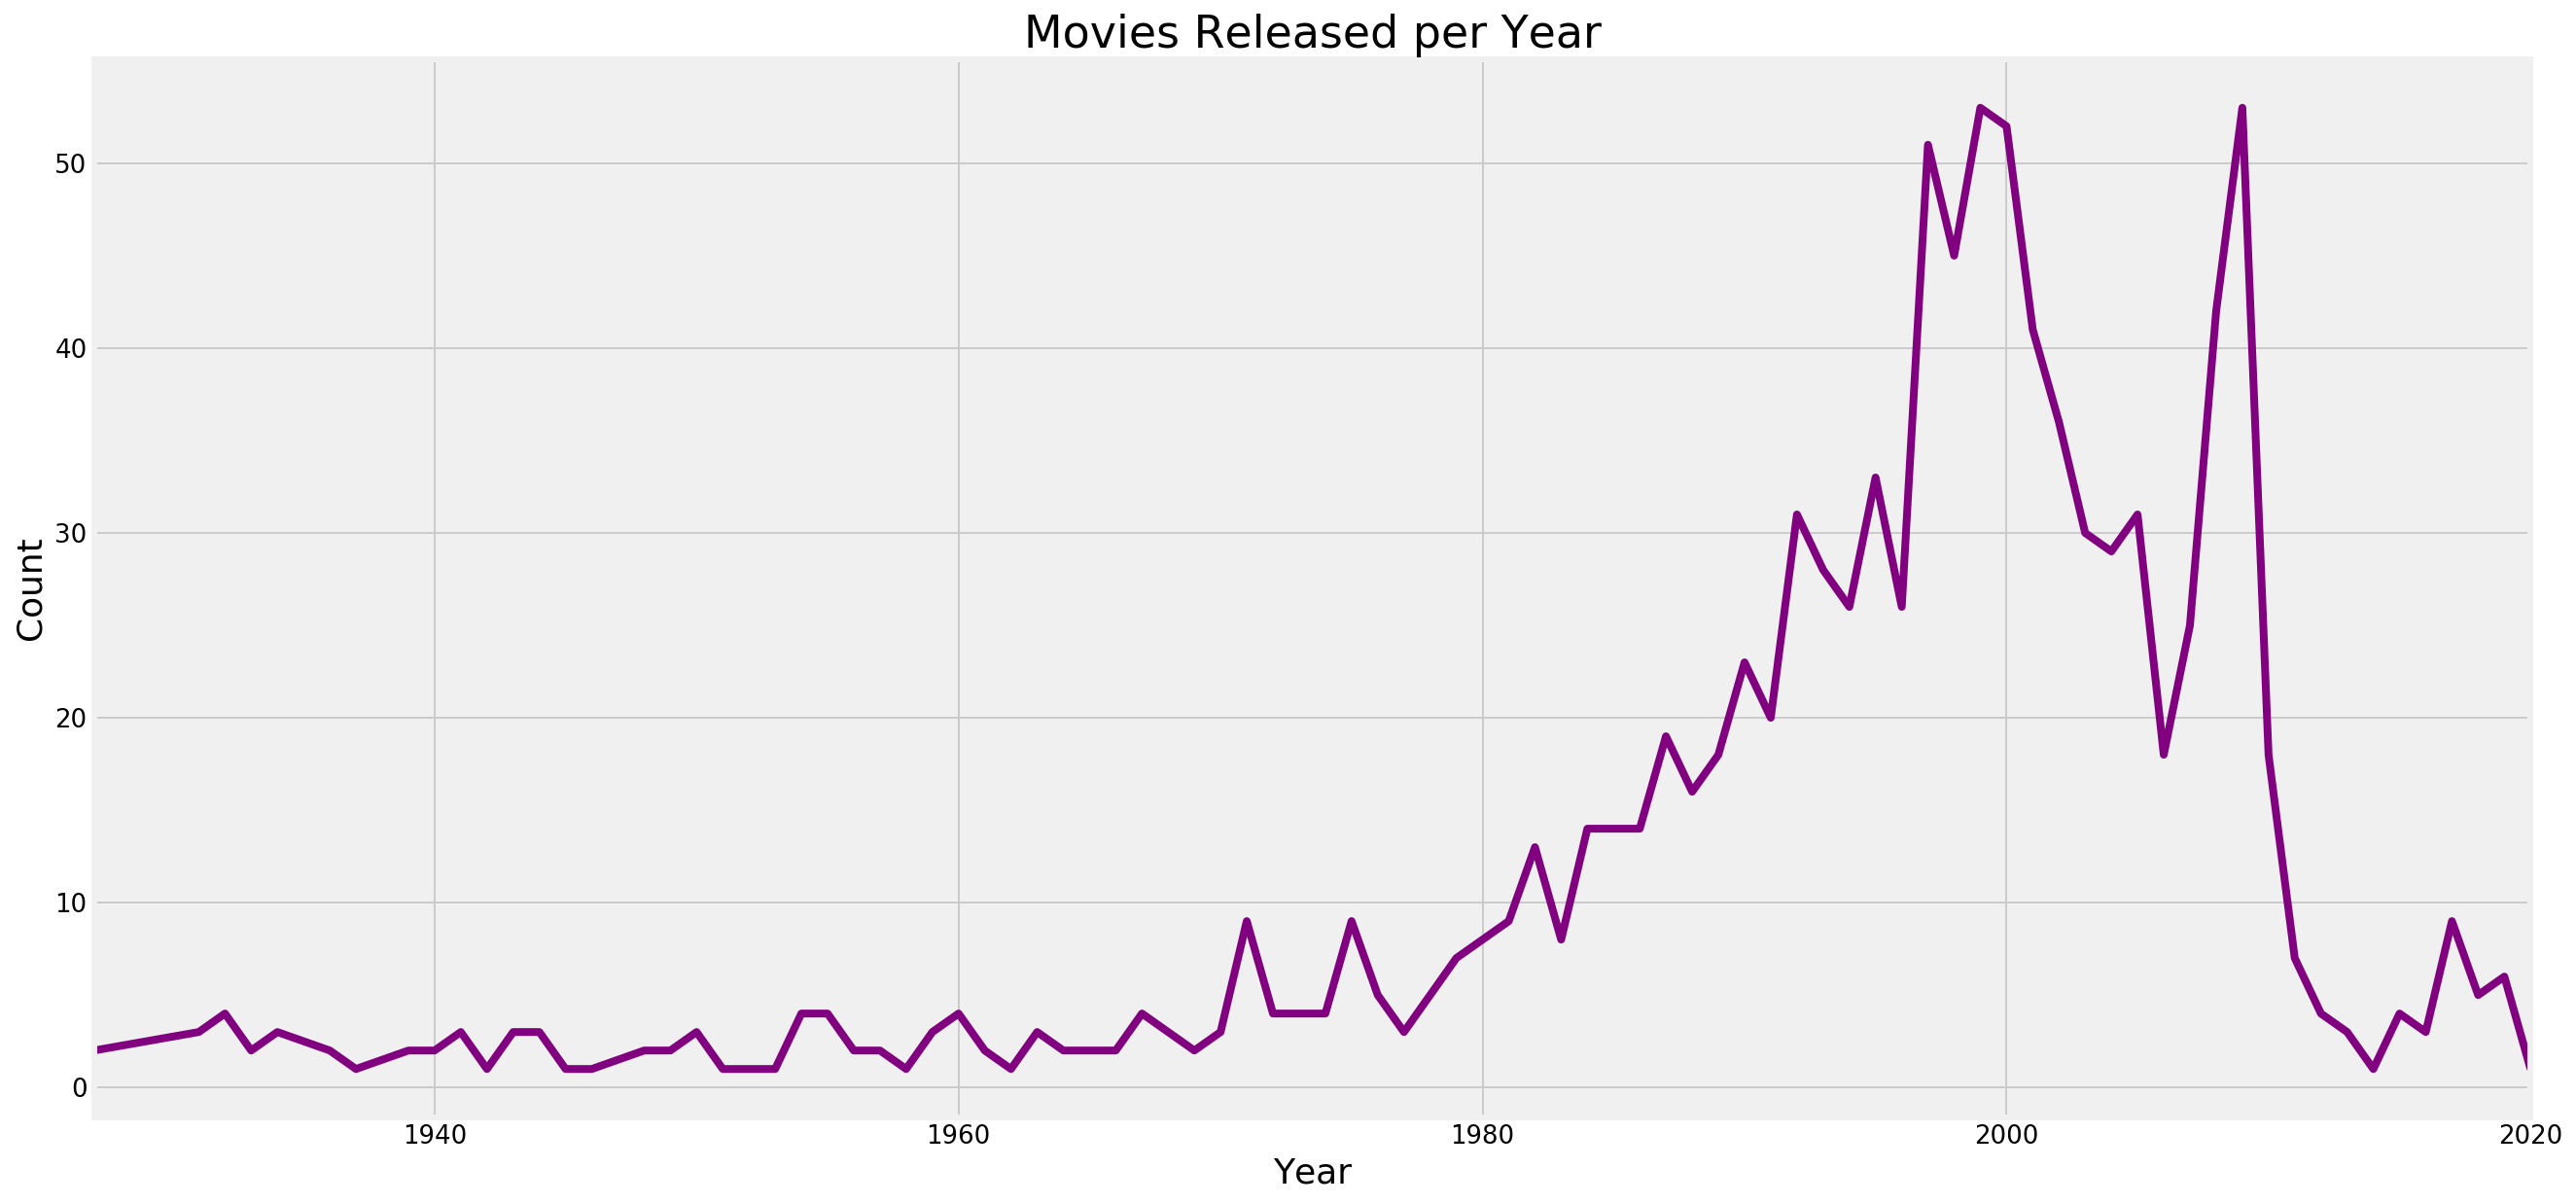

In [27]:
# Dropping Goonies 2 because it has not been released yet
per_mov = per_mov.drop(index = 59956)

ax = per_mov[['year']].groupby('year')['year'].count().plot(kind='line', figsize = (20,10), 
                                                            color = 'purple', fontsize = 13);
ax.set_alpha(0.8)
ax.set_title('Movies Released per Year', fontsize = 23);
ax.set_ylabel('Count', fontsize = 18);
ax.set_xlabel('Year', fontsize = 18);

It appears that the majority of the dialogues and quotes in the Cornell corpora is from movies that were released beween 1980 and 2010.

## Barplots per Genre

Many movies have cross-genres. I am going to create a separate dataframe called `per_genre_df` where each row is a unique genre and contains the following information in its columns: the number of characters, total word count, all the characters' lines per genre, number of movies per genre, and vader compound score. 

In [28]:
unique_genres

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War',
 'Western']

In [29]:
per_genre = {}

for genre in unique_genres:  
    
    genre_mask = mov_combo_final[genre] == 1
    
    combined_text = list((mov_combo_final[mov_combo_final[genre] == 1]['text'] + ' ').values)
    
    per_genre[genre] = [len(mov_combo_final[genre_mask]), 
                        mov_combo_final[genre_mask]['word_count'].sum(),
                        combined_text,
                        per_mov[genre].sum()
                        ]

In [30]:
per_genre_df = pd.DataFrame.from_dict(per_genre, orient='index')
per_genre_df.columns = ['num_character','total_word_count', 'all_text', 'num_mov']
per_genre_df = per_genre_df.sort_values('num_character',ascending = False)

In [31]:
per_genre_df['all_text'] = per_genre_df['all_text'].map(lambda x: ''.join(x))

In [32]:
# words per movie
per_genre_df['words_per_mov'] = round(per_genre_df['total_word_count']/per_genre_df['num_mov'],0)

# characters per movie
per_genre_df['characters_per_mov'] = round(per_genre_df['num_character']/per_genre_df['num_mov'],2)

In [33]:
per_genre_df.head()

,num_character,total_word_count,all_text,num_mov,words_per_mov,characters_per_mov
Drama,39531,5680573,What can I get you? You forgot to pay! Did you...,539,10539.0,73.34
Comedy,24945,3261418,What can I get you? You forgot to pay! Did you...,305,10693.0,81.79
Action,20494,2317644,The hallway is on fire! Shoot him! SHOOT! Tha...,265,8746.0,77.34
Crime,17753,2344215,The hallway is on fire! Shoot him! SHOOT! Tha...,239,9808.0,74.28
Adventure,14655,1766392,"Amerigo Vespucci, Excellency. ... and he deman...",190,9297.0,77.13


I am going to examine the top five and lowest five genres according to the grand total number of characters there are in its movies. One fact to note is that a character can belong to multiple movie genres, so there are overlaps between character counts.

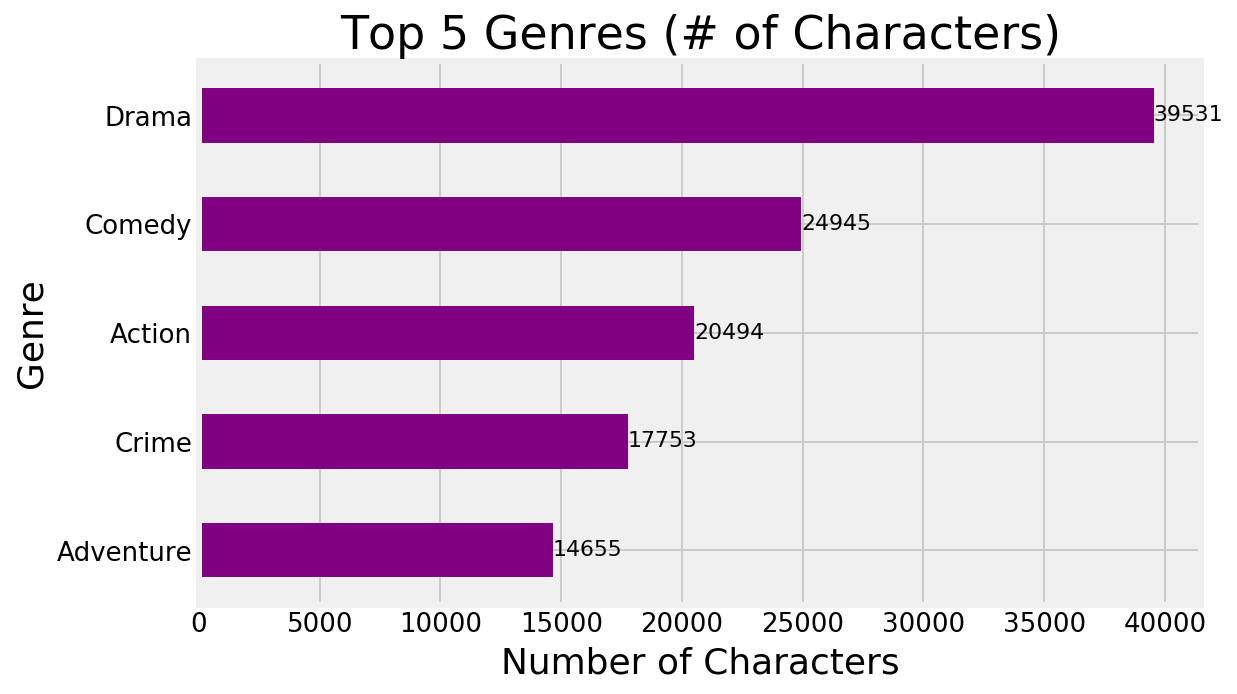

In [34]:
ax = per_genre_df['num_character'].sort_values().tail().plot(kind='barh', figsize = (8, 5), 
                                        color = 'purple', fontsize = 13);
ax.set_alpha(0.8)
ax.set_title('Top 5 Genres (# of Characters)', fontsize = 23);
ax.set_ylabel('Genre', fontsize = 18);
ax.set_xlabel('Number of Characters', fontsize = 18);

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.2, i.get_y()+.2, \
            str(round((i.get_width()), 2)), fontsize=11, color='black')


The top 5 genres in terms of its total number of characters are Drama, Comedy, Action, Action, Crime, and Adventure. This is unsurprising. If I am going to watch an action movie, I expect copious amounts of conflict between the protagonist and an unending flurry of bad guys trying to pummel him/her. 

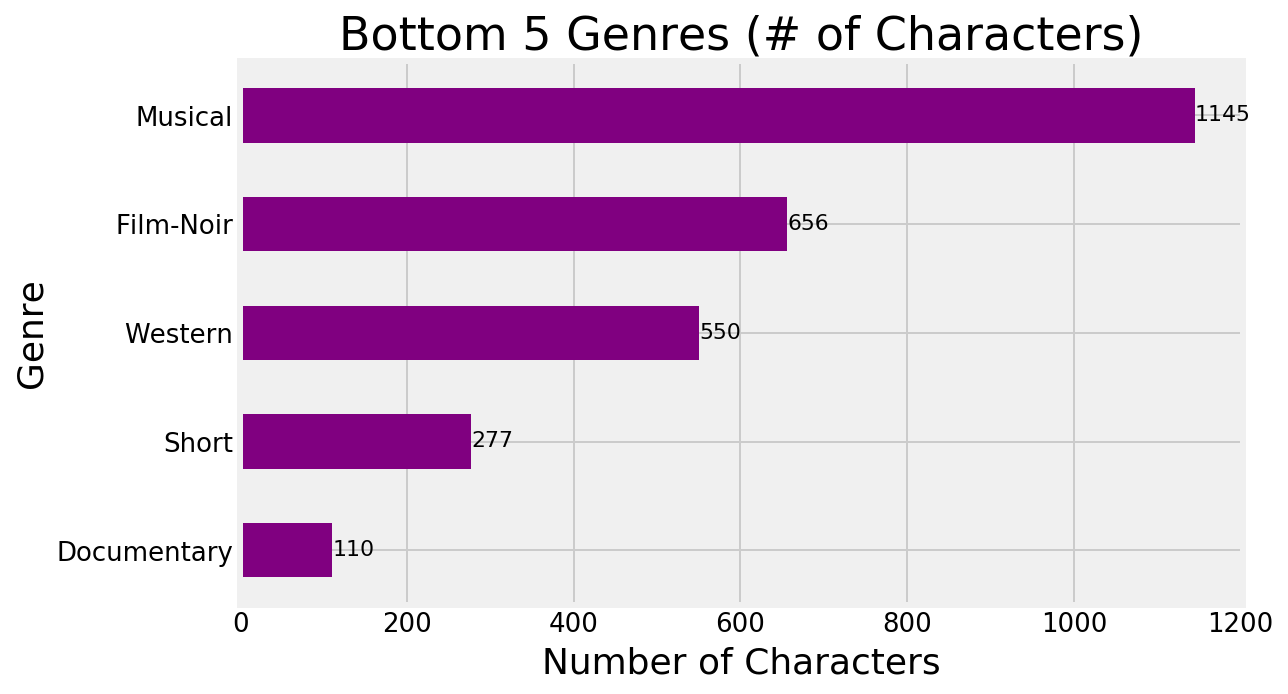

In [35]:
ax = per_genre_df['num_character'].sort_values().head().plot(kind='barh', figsize = (8, 5), 
                                        color = 'purple', fontsize = 13);
ax.set_alpha(0.8)
ax.set_title('Bottom 5 Genres (# of Characters)', fontsize = 23);
ax.set_ylabel('Genre', fontsize = 18);
ax.set_xlabel('Number of Characters', fontsize = 18);

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.2, i.get_y()+.2, \
            str(round((i.get_width()), 2)), fontsize=11, color='black')


The genres that have the least amount of total characters are mentioned above.

I will now examine the genres based on the the average number of characters per movie.

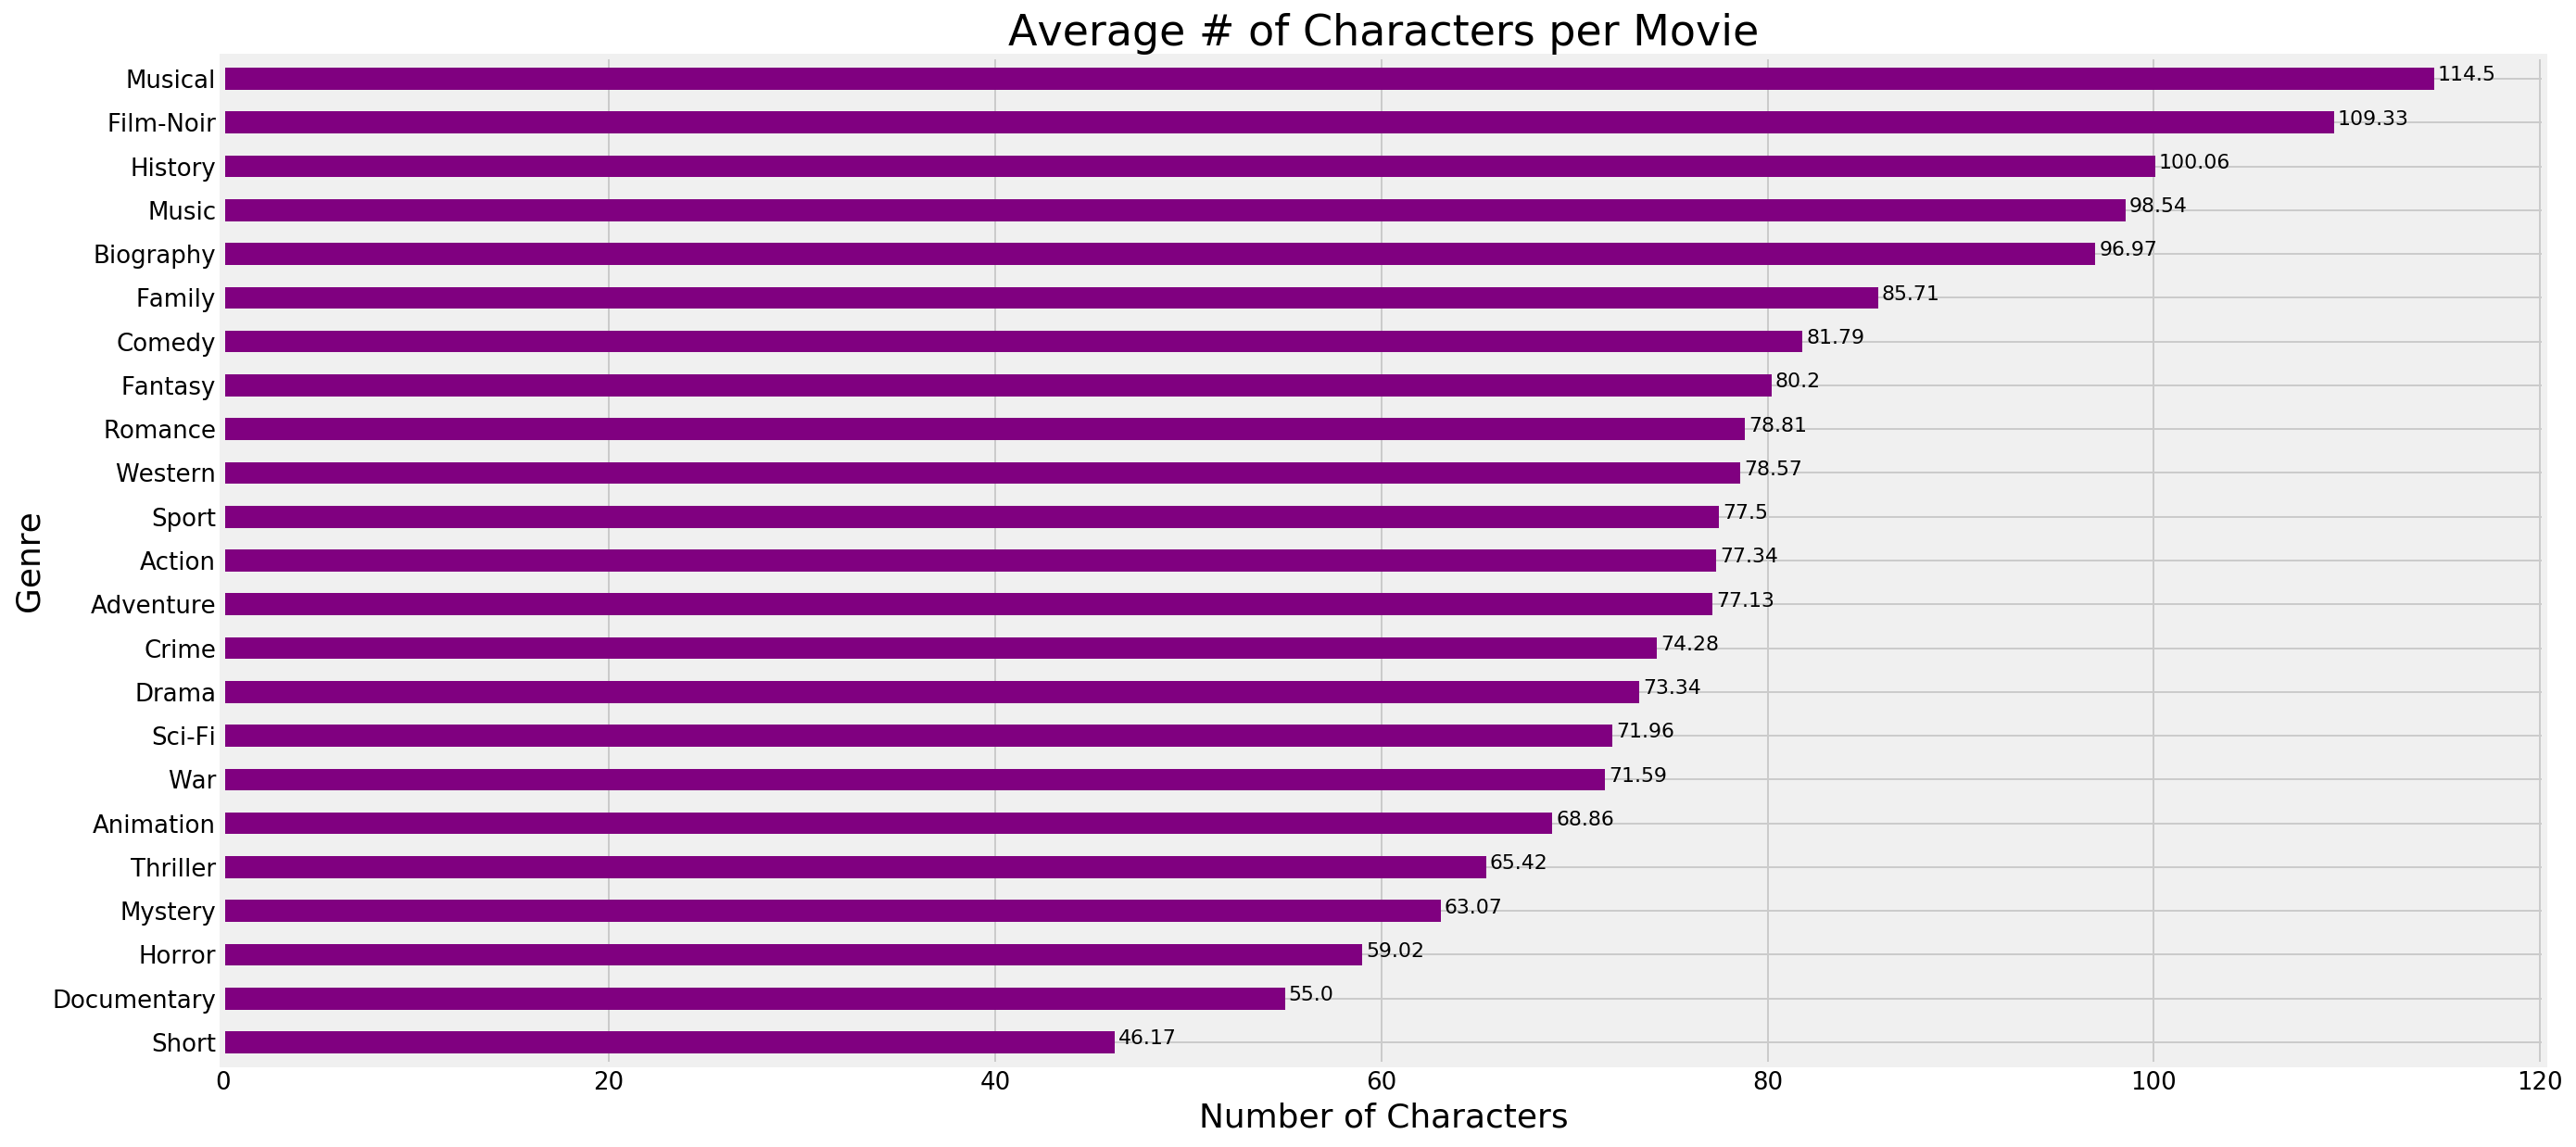

In [36]:
ax = per_genre_df['characters_per_mov'].sort_values().plot(kind='barh', figsize = (20, 10), 
                                        color = 'purple', fontsize = 13);
ax.set_alpha(0.8)
ax.set_title('Average # of Characters per Movie', fontsize = 23);
ax.set_ylabel('Genre', fontsize = 18);
ax.set_xlabel('Number of Characters', fontsize = 18);


for i in ax.patches:
    ax.text(i.get_width()+.2, i.get_y()+.2, \
            str(round((i.get_width()), 2)), fontsize=11, color='black')


Surprisingly, there is a switch. Musicals, Film-Noir, History, Music, and Biography have a higher on average number of characters. I doubt that this is dataset can be extrapolated for other movies, so this result will be taken with a grain of salt. The result purely reflects what movies there are in the dataset that I have chosen.

I will now examine the average words per movie for each drama.

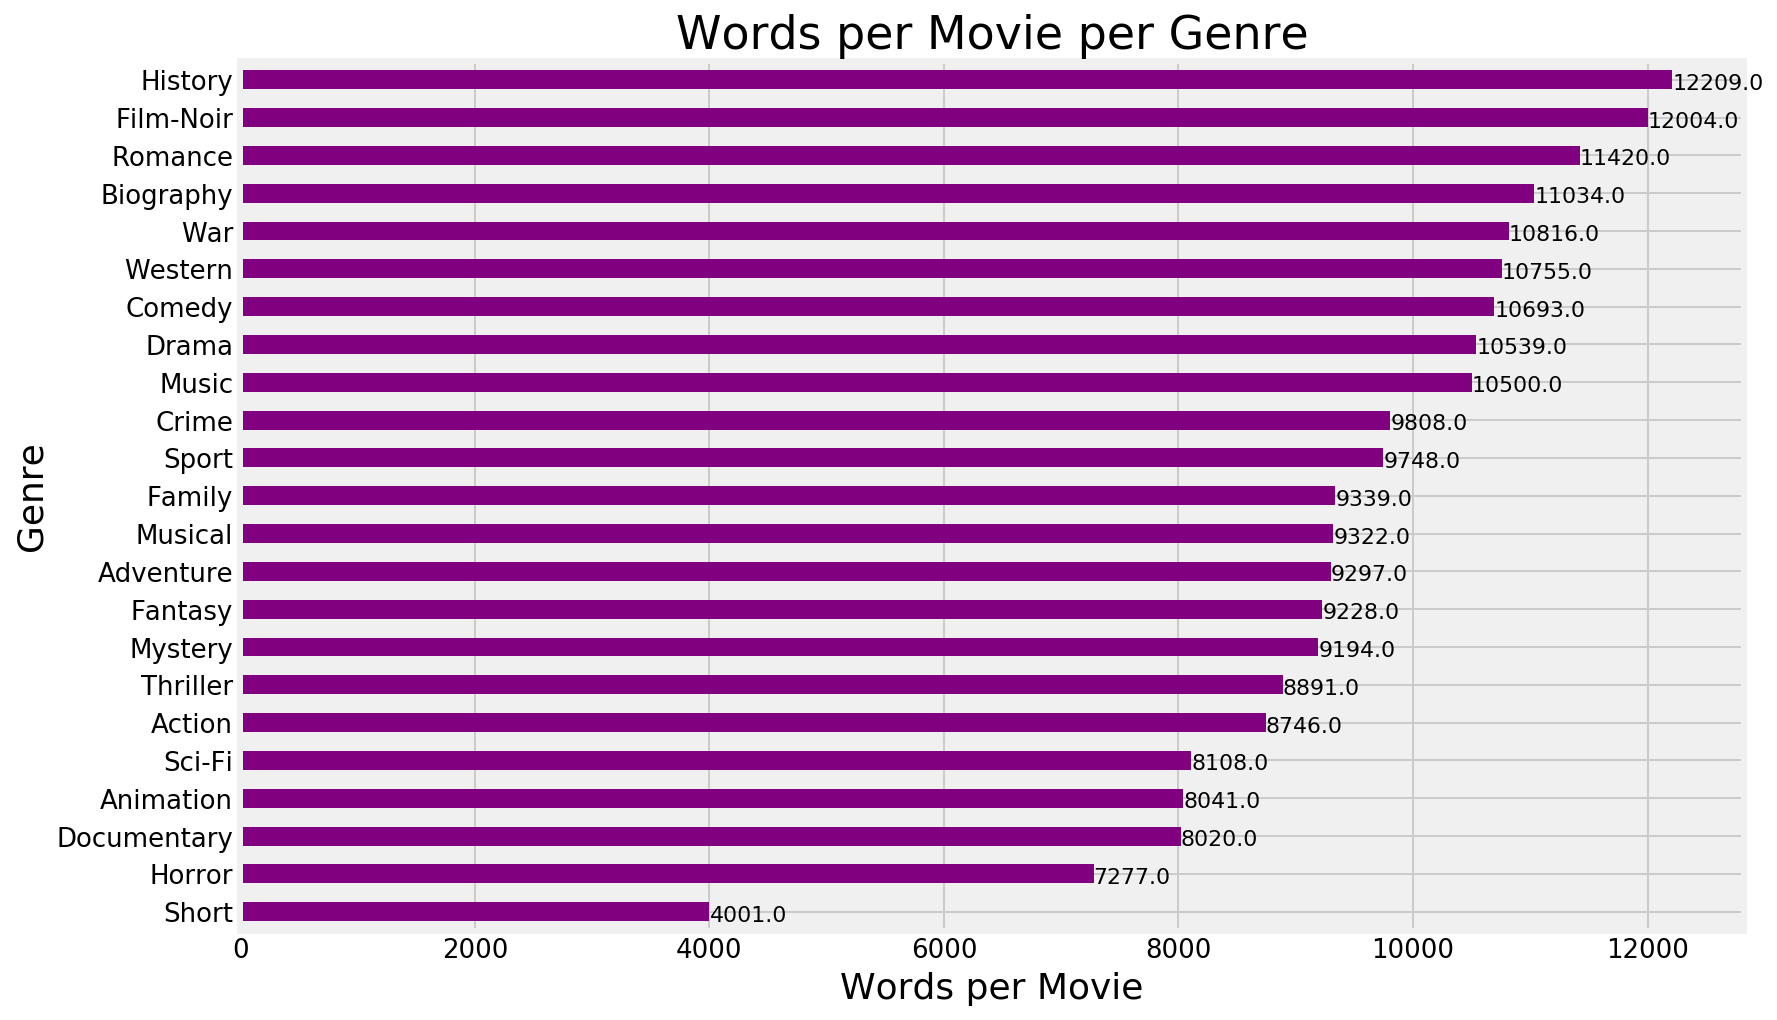

In [37]:
ax = per_genre_df['words_per_mov'].sort_values().plot(kind='barh', figsize = (12, 8), 
                                        color = 'purple', fontsize = 13);
ax.set_alpha(0.8)
ax.set_title('Words per Movie per Genre', fontsize = 23);
ax.set_ylabel('Genre', fontsize = 18);
ax.set_xlabel('Words per Movie', fontsize = 18);

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.2, i.get_y()+.0, \
            str(round((i.get_width()), 2)), fontsize=11, color='black')


Not surprisingly, based on the higher number of average characters per movie there are, there will be more words spoken in conversation and in dialogue.

### Scatterplot

I will examine the average number of characters plotted against the average number of words per movie for each genre. 

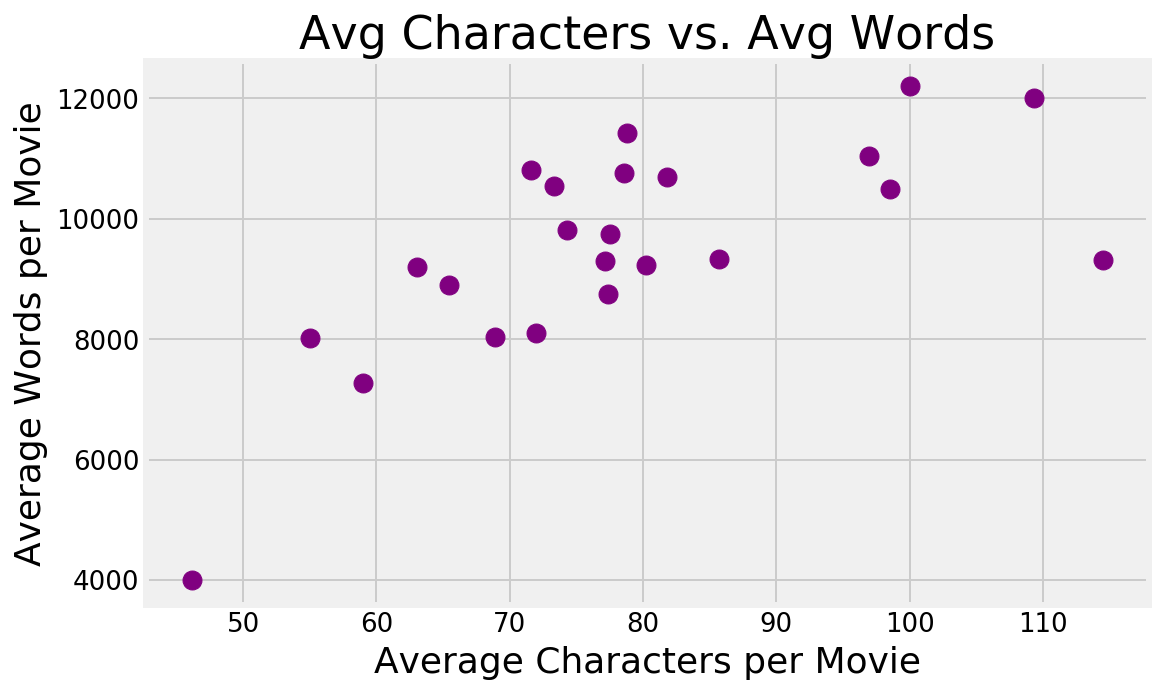

In [38]:
ax = per_genre_df[['words_per_mov','characters_per_mov']].plot(kind='scatter', 
                                                               x = 'characters_per_mov',
                                                               y = 'words_per_mov',
                                                               figsize = (8, 5),
                                                               s = 90,
                                                               color = 'purple', fontsize = 13);
ax.set_alpha(0.8)
ax.set_title('Avg Characters vs. Avg Words', fontsize = 23);
ax.set_ylabel('Average Words per Movie', fontsize = 18);
ax.set_xlabel('Average Characters per Movie', fontsize = 18);

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.2, i.get_y()+.0, \
            str(round((i.get_width()), 2)), fontsize=11, color='black')


As we can see, the results appear to share a linear relationship.

In [39]:
per_genre_df.corr()

,num_character,total_word_count,num_mov,words_per_mov,characters_per_mov
num_character,1.000000,0.994450,0.995338,0.138175,-0.127706
total_word_count,0.994450,1.000000,0.993268,0.156163,-0.138777
num_mov,0.995338,0.993268,1.000000,0.098007,-0.178466
words_per_mov,0.138175,0.156163,0.098007,1.000000,0.701635
characters_per_mov,-0.127706,-0.138777,-0.178466,0.701635,1.000000


## Histograms - Genre

I will now examine the distribution of words per character per genre. I have set a max limit of 300 words due to outliers.

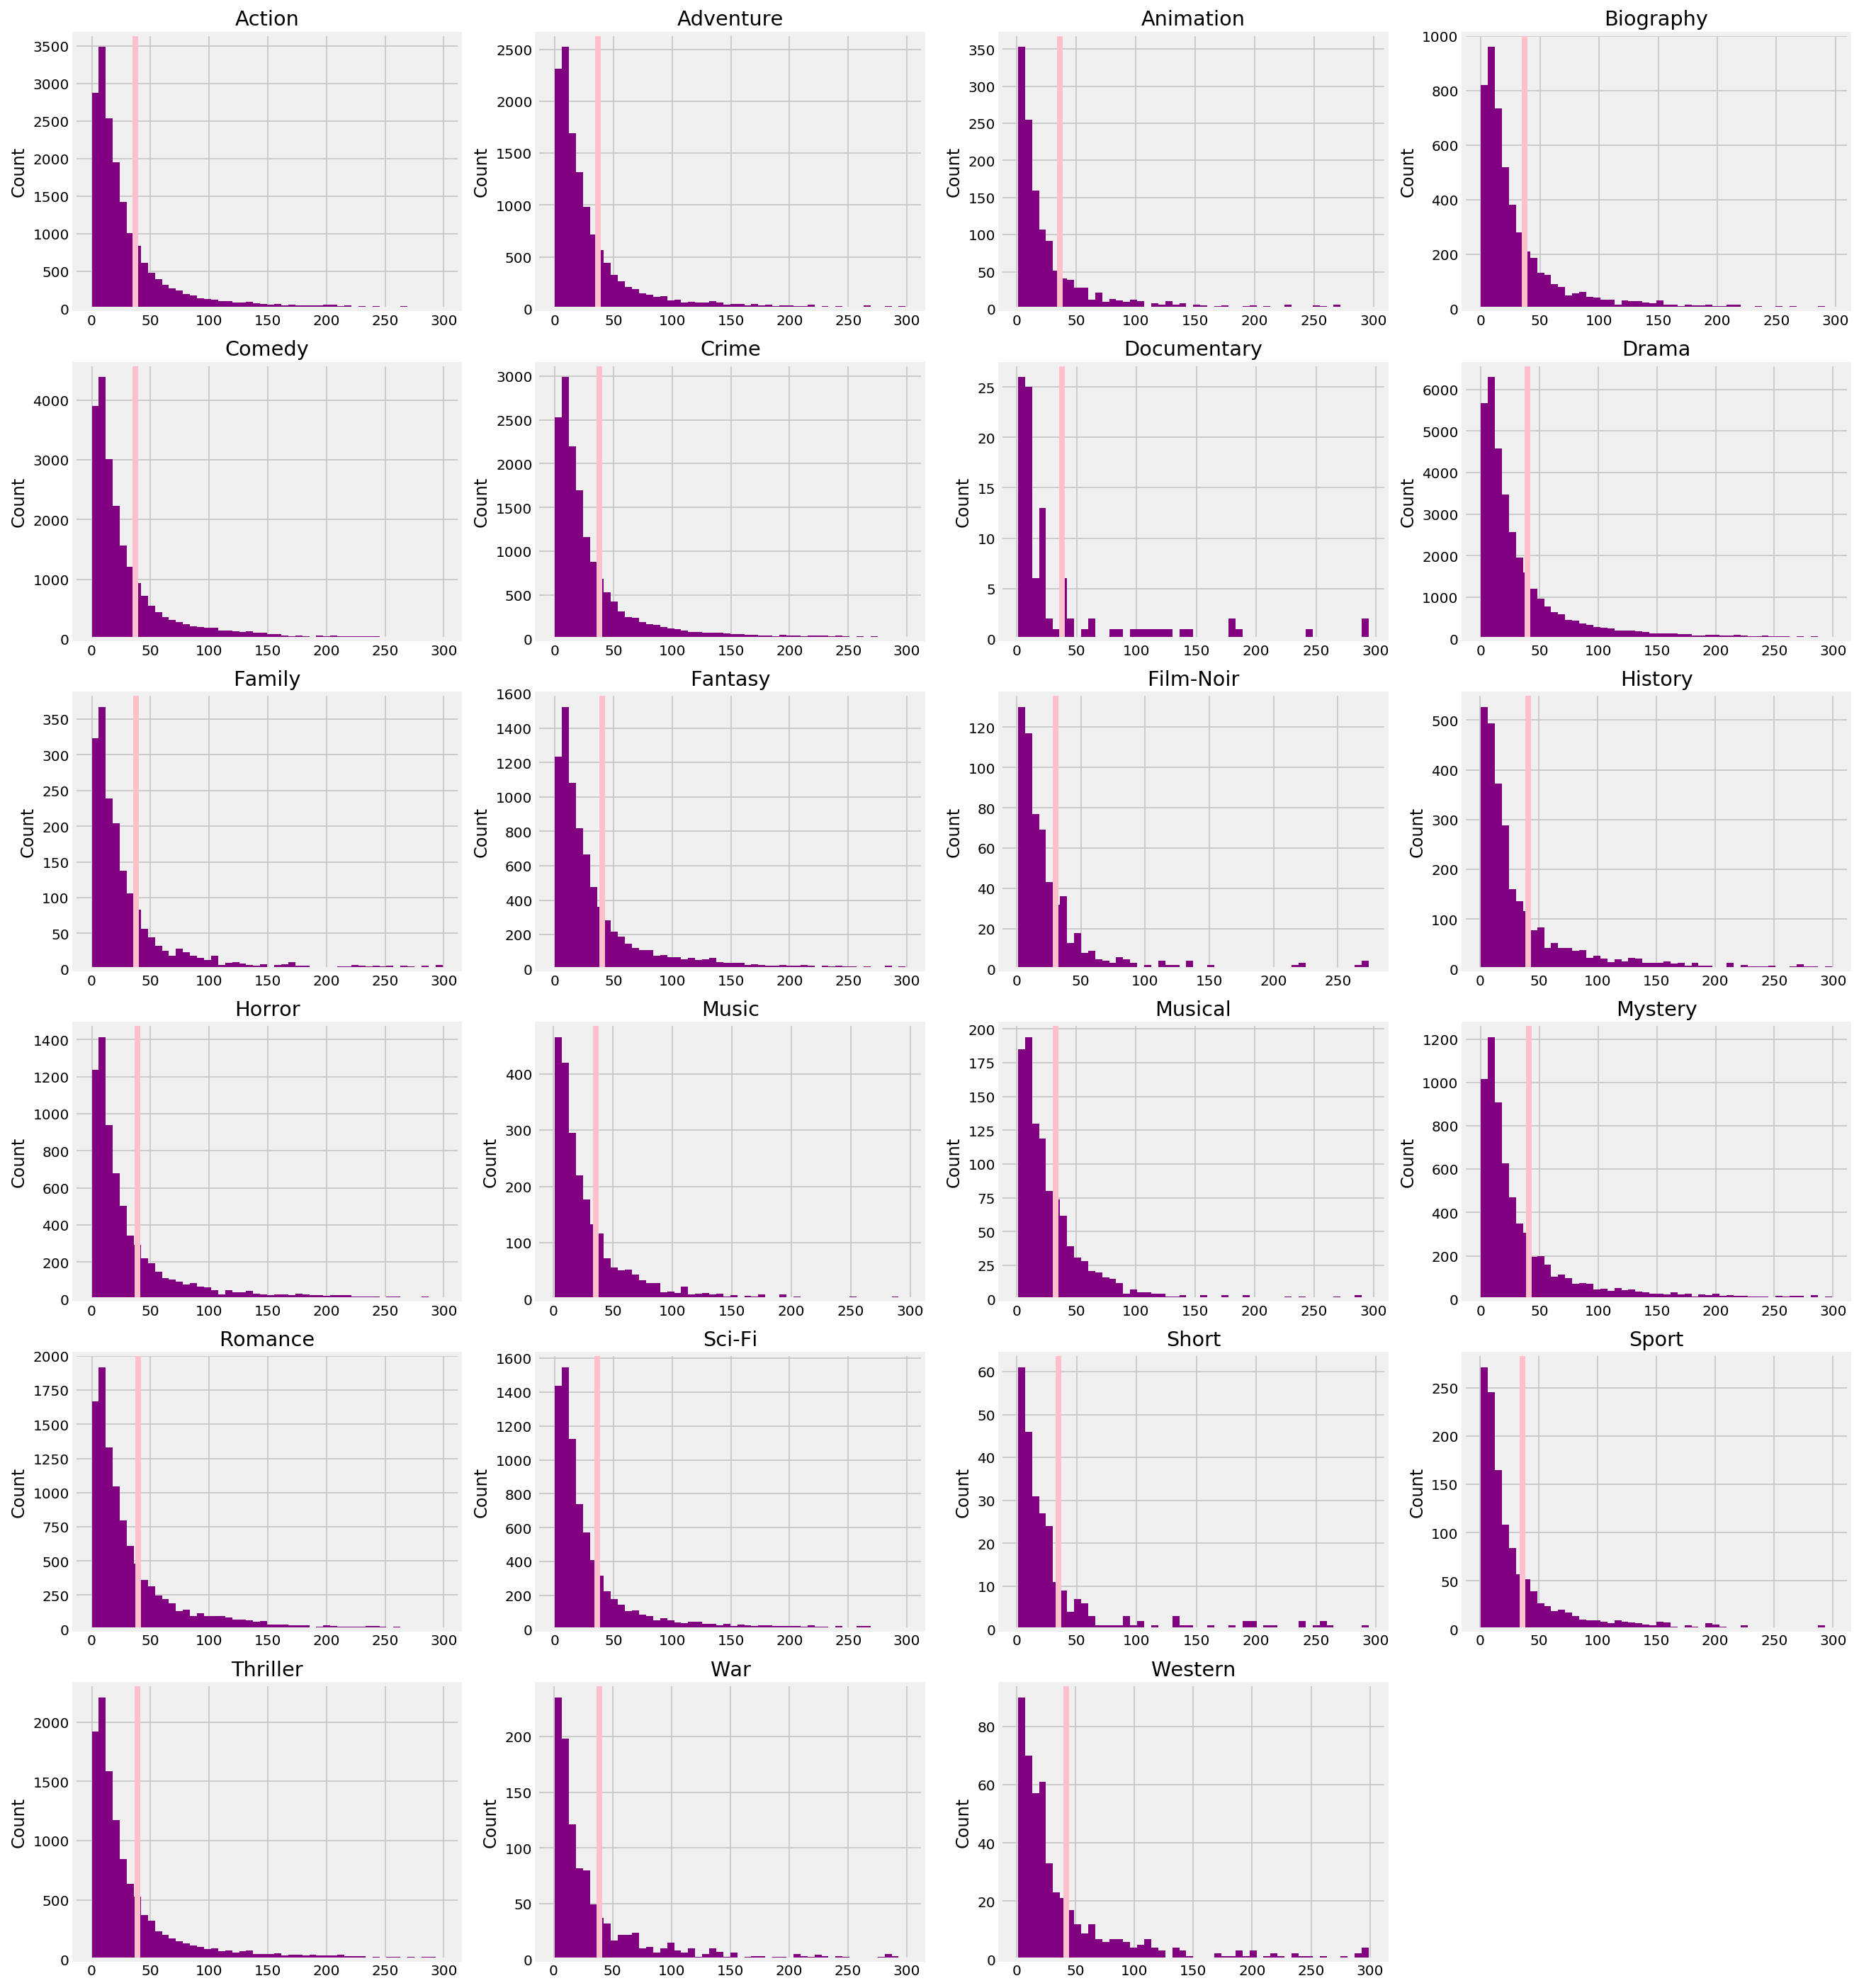

In [40]:
fig = plt.figure(figsize=(20,25))
for i, col in enumerate(unique_genres): # for index and column name 
    fig.add_subplot(6,4,1+i) # create subplots, use index to increment 
    col_data = mov_combo_final[(mov_combo_final[col] == 1)&
                    (mov_combo_final['word_count'] < 300)]['word_count']
    
    plt.hist(col_data, bins=50, color = 'purple')
    
    char_mean = col_data.mean()
    
    plt.axvline(char_mean, color = 'pink')
    
    plt.title(col)
    plt.ylabel('Count')

As you can see, all the genres exhibit a heavy positive skew in which the mode and median are smaller than the mean. This implies how there are many minor characters that only speak a few number of words. In terms of a recommender system, I need to be cautious about comparing main movie characters that tend to be verbose against characters that just say a few words and then disappear from the film.

## Top Words Based on TF-IDF
I am now going to observe the top 10 words for each genre based on its importance. The measurement of importance will be provided by TF-IDF, which consists of two parts, the term frequency and the inverse document frequency, that provide a weight of how important a particular word is accross the corpus, which is the whole collection of documents.

In this particular case, the documents are each individual character's lines in the mov_combo_final's `text` column, and the corpus is the collection of all of the lines.

Parameters:

`min_df` = 0.1
- Ignoring terms that appear less than 10% of the documents

`max_df` = 0.95
- Ignoring terms that appear more than 95% of the documents

In [41]:
mov_combo_final.head(1)

,imdb_title,character,text,tokenized_text,word_count,vader,genre,vader_cmpd,char_count,num_genre,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,10 Things I Hate About You (1999),bartender,What can I get you? You forgot to pay!,"[what, can, i, get, you, you, forgot, to, pay]",9,"{'neg': 0.195, 'neu': 0.805, 'pos': 0.0, 'comp...","Comedy,Drama,Romance",-0.1759,38,3,...,0,0,0,1,0,0,0,0,0,0


First, I need to clean the `text` column by using regex and subsequently create a `clean_text` column.

In [42]:
mov_combo_final['clean_text'] = mov_combo_final['text'].map(lambda x: re.sub('[^A-Za-z]+', ' ', x))

Adding commonplace stop words to the `sw` variable.

In [43]:
sw = stopwords.words('english')
sw = sw+ ['another', 'anything', 'around', 'away', 'back', 'better', 'seconds','area',
'call', 'come', 'could', 'door', 'even', 'face', 'find', 'first', 'get', 'months', 'round', 'book',
'give', 'go', 'going', 'gonna', 'good', 'got', 'head', 'hey', 'keep', 'know', 'keeping','booth','finish','due',
'last', 'let', 'like', 'little', 'long', 'look', 'looking', 'looks', 'make', 'man', 'maybe', 'mean', 'much',
'must', 'need', 'never', 'new', 'nothing', 'oh', 'okay', 'one', 'people', 'place', 'please', 'nicky',
'put', 'really', 'right', 'said', 'say','see', 'sir', 'something', 'still', 'stop', 'sure', 'take', 'tell', 
'thing', 'think', 'thought', 'three', 'time', 'two', 'us', 'want','way', 'well', 'work', 'would', 'yeah', 
'yes', 'early', 'wake', 'expect', 'keeps', 'roof', 'sight', 'charge', 'careful', 'worse', 'doors', 
'sort', 'seat', 'wearing', 'shoulder', 'bag', 'given', 'stick', 'train', 'calling', 'suit', 'outta', 'happening', 
'giving', 'twelve', 'flying', 'box', 'worked', 'wind','bridge', 'large', 'hier','toward',
'command', 'tries', 'protect', 'act', 'explain', 'bar', 'till', 'information', 'ing',
'wonder', 'cross', 'fun', 'group', 'watches', 'slowly', 'begin', 'sun', 'huge', 'brings',
'reach', 'closer', 'king', 'none', 'anywhere', 'center', 'low', 'zachetti',
'several', 'hole', 'join', 'appears', 'land', 'view', 'thinks', 'works', 'throw', 'unless', 'turned',
'holds', 'quickly', 'walking', 'cool', 'ones', 'foot', 'quiet', 'position', 
'mon', 'lock', 'return', 'child', 'short', 'rock', 'begins', 'corner', 'company', 'shall', 'except', 
'fifty', 'perhaps', 'falls', 'miles', 'state', 'gives', 'caught', 'met', 'lucky', 'person', 'sitting', 
'hurry', 'nine', 'truck', 'station', 'bet', 'lead', 'weeks', 'changed', 'field',
'grabs', 'blue', 'reaches', 'sometimes', 'somewhere', 'cannot', 'cops', 'screen',
'ah', 'brought', 'eat', 'beat', 'doctor', 'hour', 'piece', 'drive', 'welcome', 'speak', 'read', 'happy', 'reason',
'ring', 'enter', 'continue', 'mark', 'signal', 'become','besides','certain',
'eh', 'jesus', 'lights', 'evening', 'mistake', 'using', 'honestly',
'desk', 'radio', 'jack', 'william', 'finished', 'meant', 'lord', 'enjoy', 'named', 'bunch', 
'month', 'cover', 'likes', 'kitchen', 'dressed', 'balls', 'seconds', 'area', 'third', 'address',
'abe', 'lockyer', 'meant', 'martha', 'mark', 'marie', 'steve',
'papers', 'named', 'neither', 'neither', 'lights', 'yesterday','chair',
'lava', 'words', 'dorothy', 'tree', 'answer', 'calls', 'sam', 'kept', 
'looked', 'closed', 'staring', 'lands', 'within', 'den', 'probably', 'present', 'power', 
'deal', 'plenty', 'plan', 'der', 'tree', 'kept', 'jerry', 'key', 'ray'
'figure', 'accept', 'neither', 'sake', 'meant', 'ran', 'relax', 'roger', 'legs',
'drops', 'happens', 'tight', 'concert', 'shows', 'red', 'learn', 'meant', 'aboard', 
'outside', 'tray', 'eight', 'thousand', 'certainly', 'mary',
'trip', 'blow', 'picks', 'neck', 'notice', 'favorite', 'wrote', 'bathroom', 
'cover', 'kinda', 'public', 'area', 'places', 'ice', 'steps', 'age', 'arms',
'personal', 'beyond', 'ok', 'broken', 'towards', 'young', 'hall', 'graham', 'step', 
'sticks', 'straight', 'folks', 'professional', 'moved', 'pool', 'gift', 'born', 'dressed', 
'possible', 'sell', 'gettin', 'surprise', 'simple', 'sister', 'space', 'tape', 'th', 'certainly', 
'picked','herr', 'roll', 'named', 'grow', 'handle', 'spot', 'sand', 
'aaron', 'kick', 'figured', 'flat', 'forgot', 'towards', 'gather', 'glass']

          
# removing duplicate words
sw = set(sw)
sw = list(sw)

Instantiating the TFIDF feature extraction to examine important words that help define the movie genres.

In [44]:
tfidf = TfidfVectorizer(stop_words = sw, min_df = 0.01, max_df = 0.95)

The following `top_tfidf_words()` function will return the top weighted words for whichever genre is inputted.

In [45]:
def top_tfidf_words(genre=0, num_words = 10):    
    num_film = len(mov_combo_final[mov_combo_final[unique_genres[genre]] == 1].drop_duplicates('imdb_title'))
    tfidf.fit_transform(mov_combo_final[mov_combo_final[unique_genres[genre]] == 1]['clean_text'])
    df = pd.DataFrame.from_dict(dict(zip(tfidf.get_feature_names(),tfidf.idf_)), orient='index')
    df.columns = ['tfidf_score']
    df = df.sort_values(by='tfidf_score', ascending = False)
    print(f"Top {num_words} {unique_genres[genre]} Words\n************************")
    print(df.head(num_words))
    print('\n')
    print(f'Based on {num_film} movies')

In [46]:
top_tfidf_words(0, 15)

Top 15 Action Words
************************
           tfidf_score
dream         5.600060
missing       5.600060
cars          5.595217
prison        5.595217
daughter      5.595217
battle        5.585602
mom           5.580829
code          5.576078
dying         5.576078
gold          5.566644
dad           5.561960
asshole       5.557298
bank          5.552658
bullshit      5.552658
questions     5.552658


Based on 265 movies


The top words for Action films seem to be quite family oriented with the words 'daughter', 'mom', and 'dad'. Action related words such as 'missing', 'prison', 'battle', and 'dying' appear to be more appropriate.

In [47]:
top_tfidf_words(1, 10)

Top 10 Adventure Words
************************
         tfidf_score
history     5.595393
chief       5.588659
fuck        5.581970
playing     5.581970
bitch       5.581970
goddamn     5.575325
kiss        5.575325
count       5.575325
buy         5.575325
message     5.575325


Based on 191 movies


It is interesting to note that there are many swear words in Adventure character lines. Perhaps they are tasked with a high-stakes situation.

In [48]:
top_tfidf_words(2, 10)

Top 10 Animation Words
************************
            tfidf_score
mode           5.490617
gentlemen      5.490617
near           5.490617
transforms     5.490617
needs          5.490617
tired          5.490617
nemo           5.490617
noise          5.490617
message        5.490617
goodbye        5.490617


Based on 22 movies


The top 10 animation words do not seem to follow any pattern.

In [49]:
top_tfidf_words(3, 10)

Top 10 Biography Words
************************
           tfidf_score
royal         5.574533
beg           5.574533
questions     5.574533
private       5.574533
tv            5.557439
secret        5.557439
bastard       5.557439
forgive       5.557439
listening     5.557439
honor         5.557439


Based on 58 movies


Biography films most likely feature important individuals, and based on the top words it seems that the biography films deal with drama with a royal family. 

In [50]:
top_tfidf_words(4, 10)

Top 10 Comedy Words
************************
          tfidf_score
mad          5.591079
amazing      5.591079
liked        5.591079
buddy        5.583205
eating       5.575393
starting     5.563787
law          5.563787
cute         5.563787
quit         5.559948
holy         5.559948


Based on 305 movies


Overall, the top Comedy words seem to have a positive overall sentiment.

In [51]:
top_tfidf_words(5, 10)

Top 10 Crime Words
************************
           tfidf_score
accident      5.596980
fat           5.596980
listening     5.591409
fair          5.591409
cost          5.591409
message       5.580359
bucks         5.580359
lunch         5.574880
arrest        5.574880
cell          5.569430


Based on 239 movies


The top Crime words deal with conflict which is expected, such as 'accident', 'cost', 'arrests', and 'problems'. It is mind boggling to see why 'fat' is the top word.

In [52]:
top_tfidf_words(6, 10)

Top 10 Documentary Words
************************
           tfidf_score
hook          4.610918
send          4.610918
seriously     4.610918
hits          4.610918
setting       4.610918
share         4.610918
heroin        4.610918
usual         4.610918
shhh          4.610918
heaven        4.610918


Based on 2 movies


The top documentary words appear to be ominous as it seems to deal with heroin. There are only 2 Documentary movies in the corpus however.

In [53]:
top_tfidf_words(7, 10)

Top 10 Drama Words
************************
            tfidf_score
dress          5.598414
proud          5.598414
sex            5.595904
jail           5.595904
offer          5.593401
murder         5.593401
message        5.593401
quit           5.583451
christmas      5.580979
completely     5.578513


Based on 539 movies


According to Richard Walter's Essentials of Screenwriting, 'sex' and 'murder' are top themes in order to induce conflict.

In [54]:
top_tfidf_words(8, 10)

Top 10 Family Words
************************
          tfidf_score
husband      5.538447
marry        5.538447
smell        5.538447
security     5.538447
spend        5.538447
fair         5.538447
beside       5.538447
clock        5.538447
pass         5.538447
fly          5.538447


Based on 24 movies


Neat, the top Family words are quite self-explanatory and most likely very applicable to the targeted audience.

In [55]:
top_tfidf_words(9, 10)

Top 10 Fantasy Words
************************
           tfidf_score
shadow        5.586269
distance      5.575687
mad           5.575687
worth         5.575687
kiss          5.575687
swear         5.575687
um            5.565216
attention     5.565216
daughter      5.565216
beside        5.565216


Based on 115 movies


Not sure of what to have expected for Fantasy films. 

In [56]:
top_tfidf_words(10, 10)

Top 10 Film-Noir Words
************************
           tfidf_score
swear         5.408242
music         5.408242
star          5.408242
different     5.408242
instead       5.408242
knees         5.408242
uncle         5.408242
lately        5.408242
letters       5.408242
cost          5.408242


Based on 6 movies


For the top Film Noir words, I would have expected words that deal with slightly more of a negative sentiment.

In [57]:
top_tfidf_words(11, 10)

Top 10 History Words
************************
          tfidf_score
figure       5.543617
india        5.543617
arrested     5.543617
bloody       5.543617
tired        5.543617
lying        5.543617
risk         5.543617
pulls        5.543617
wounded      5.513764
lived        5.513764


Based on 31 movies


History often deals with a bloody past based on violence.

In [58]:
top_tfidf_words(12, 10)

Top 10 Horror Words
************************
         tfidf_score
kidding     5.591294
leaves      5.591294
broke       5.579173
store       5.579173
swear       5.579173
fault       5.579173
stopped     5.579173
knife       5.567196
clock       5.567196
burn        5.567196


Based on 137 movies


The top horror words perhaps deal with mistakes being made and obviously knives and burns. Horror films usually deal with a healthy combination of dread and violence.

In [59]:
top_tfidf_words(13, 10)

Top 10 Music Words
************************
        tfidf_score
sense      5.553097
soft       5.553097
prince     5.553097
heavy      5.553097
brad       5.553097
fact       5.553097
save       5.553097
luck       5.553097
news       5.553097
seated     5.516729


Based on 26 movies


In [60]:
top_tfidf_words(14, 10)

Top 10 Musical Words
************************
            tfidf_score
absolutely     5.479084
class          5.479084
entrance       5.479084
empty          5.479084
dr             5.479084
dollar         5.479084
costume        5.479084
taken          5.479084
chorus         5.479084
fact           5.479084


Based on 10 movies


Music and Musical genres are grandiose in nature and most of the words most likely come from the films' lyrics.

In [61]:
top_tfidf_words(15, 11)

Top 11 Mystery Words
************************
          tfidf_score
problems     5.579653
self         5.579653
pleasure     5.579653
drunk        5.579653
lunch        5.566749
asleep       5.566749
feels        5.566749
record       5.566749
future       5.566749
cash         5.566749
favor        5.566749


Based on 119 movies


Many mystery films deal with some unexplainable event that occur overnight. Perhaps cash was stolen.

In [62]:
top_tfidf_words(16, 10)

Top 10 Romance Words
************************
          tfidf_score
america      5.588587
sleeping     5.588587
hardly       5.580357
fool         5.580357
human        5.580357
note         5.580357
offer        5.572193
store        5.572193
beach        5.572193
smoke        5.572193


Based on 151 movies


Interesting to note how the word 'love' is not included. Perhaps it is too commonplace in accross the texts.

In [63]:
top_tfidf_words(17, 10)

Top 10 Sci-Fi Words
************************
         tfidf_score
empty       5.572188
attack      5.550209
star        5.550209
heads       5.539398
medical     5.539398
dad         5.539398
bay         5.539398
calm        5.539398
officer     5.539398
forever     5.539398


Based on 121 movies


Usually Sci-Fi movies deal with hi-tech futuristic technologies, and it is hard to gauge based on singular words.

In [64]:
top_tfidf_words(18, 10)

Top 10 Short Words
************************
           tfidf_score
york          5.241327
portraits     5.241327
points        5.241327
electrons     5.241327
plates        5.241327
piss          5.241327
piercing      5.241327
emerald       5.241327
pick          5.241327
engine        5.241327


Based on 6 movies


The top short words appear to be a random combo of words.

In [65]:
top_tfidf_words(19, 10)

Top 10 Sport Words
************************
         tfidf_score
fool        5.533316
fall        5.533316
horse       5.533316
pound       5.533316
babe        5.533316
base        5.533316
suppose     5.533316
reading     5.533316
beer        5.533316
dark        5.533316


Based on 18 movies


The connection between these words and the Sports genre is not very clear.

In [66]:
top_tfidf_words(20, 10)

Top 10 Thriller Words
************************
            tfidf_score
music          5.593697
smile          5.586317
ray            5.578991
difference     5.578991
smiles         5.571718
stares         5.571718
code           5.571718
dangerous      5.571718
following      5.571718
locked         5.571718


Based on 204 movies


The top thriller words, 'stares', 'code', 'dangerous', 'following', and 'locked', appear to be quite ominous and perhaps used in a precarious situation.

In [67]:
top_tfidf_words(21, 10)

Top 10 War Words
************************
          tfidf_score
dance        5.465908
killing      5.465908
smile        5.465908
slow         5.465908
sky          5.465908
size         5.465908
single       5.465908
audience     5.465908
husband      5.465908
idiot        5.465908


Based on 17 movies


The top War related words seem to be more life or death oriented rather than the violence.

In [68]:
top_tfidf_words(22, 10)

Top 10 Western Words
************************
            tfidf_score
brad           5.365825
howdy          5.365825
herd           5.365825
silver         5.365825
pilgrim        5.365825
edwards        5.365825
sweetheart     5.365825
catches        5.365825
ponies         5.365825
empty          5.365825


Based on 7 movies


The top Western words based on the 7 films are agriculture related such as 'farmers', 'reins', and 'herd'.

In [72]:
# dataframe pickle for modeling

mov_combo_final.to_pickle('../data/mov_model.pkl')

# Proceed to Notebook 4: SVD Modeling